>📘 Learning Objectives
>
> 1. How to crop a single data file
> 2. How to create a data cube (DataSet) with `xarray`
> 3. Extract variables, temporal slices, and spatial slices from an `xarray` dataset
>


## Summary

In this examples we will use the [xarray](https://xarray.dev/) and [earthaccess](https://nsidc.github.io/earthaccess/) to subset data and make figures.

For this tutorial we will use the [GHRSST Level 4 MUR Global Foundation Sea Surface Temperature Analysis](https://cmr.earthdata.nasa.gov/search/concepts/C1996881146-POCLOUD.html) (v4.1) data. This is much higher resolution data than the AVHRR data and we will do spatially subsetting to a small area of interest.

#### For those not working in the JupyterHub

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nmfs-opensci/NOAAHackDays/blob/main/topics-2025/2025-02-14-earthdata/2-subset-and-plot.ipynb) and then create a code cell and run `pip install earthaccess`

### Import Required Packages

In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
from pprint import pprint

import earthaccess
import xarray as xr

## Authenticate to NASA Earthdata

We will authenticate our Earthaccess session, and then open the results like we did in the Search & Discovery section.

In [2]:
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

## Get a vector of urls to our nc files

In [3]:
short_name = 'MUR-JPL-L4-GLOB-v4.1'
version = "4.1"
date_start = "2020-01-01"
date_end = "2020-04-01"
date_range = (date_start, date_end)
# min lon, min lat, max lon, max lat
bbox = (-75.5, 33.5, -73.5, 35.5)  

results = earthaccess.search_data(
    short_name = short_name,
    version = version,
    cloud_hosted = True,
    temporal = date_range,
    bounding_box = bbox,
)
len(results)

93

In [5]:
results[0]

Collection: {'Version': '4.1', 'ShortName': 'MUR-JPL-L4-GLOB-v4.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180, 'SouthBoundingCoordinate': -90, 'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 90}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2020-01-01T21:00:00.000Z', 'BeginningDateTime': '2019-12-31T21:00:00.000Z'}}
Size(MB): 679.0388813018799
Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20200101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc']

## Crop and plot one netCDF file

Each MUR SST `netCDF` file is large so I do not want to download. Instead we will subset the data on the server side. We will start with one file.



In [4]:
fileset = earthaccess.open(results[0:1])
ds = xr.open_dataset(fileset[0])

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
ds

<xarray.Dataset> Size: 29GB
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 8B 2020-01-01T09:00:00
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 5GB ...
    analysis_error    (time, lat, lon) float64 5GB ...
    mask              (time, lat, lon) float32 3GB ...
    sea_ice_fraction  (time, lat, lon) float64 5GB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 5GB ...
    sst_anomaly       (time, lat, lon) float64 5GB ...
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

Note that `xarray` works with "lazy" computation whenever possible. In this case, the metadata are loaded into JupyterHub memory, but the data arrays and their values are not — until there is a need for them.

Let's print out all the variable names.

In [5]:
for v in ds.variables:
    print(v)

time
lat
lon
analysed_sst
analysis_error
mask
sea_ice_fraction
dt_1km_data
sst_anomaly


Of the variables listed above, we are interested in `analysed_sst`.

In [6]:
ds.variables['analysed_sst'].attrs

{'long_name': 'analysed sea surface temperature',
 'standard_name': 'sea_surface_foundation_temperature',
 'units': 'kelvin',
 'valid_min': -32767,
 'valid_max': 32767,
 'comment': '"Final" version using Multi-Resolution Variational Analysis (MRVA) method for interpolation',
 'source': 'MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTA_G-NAVO, AVHRRMTB_G-NAVO, iQUAM-NOAA/NESDIS, Ice_Conc-OSISAF'}

### Subsetting

In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection/regridding, and file aggregation. What does subsetting mean? To **subset** means to extract only the portions of a dataset that are needed for a given purpose. 

There are three primary types of subsetting that we will walk through: 
1. Temporal
2. Spatial
3. Variable

In each case, we will be excluding parts of the dataset that are not wanted using `xarray`. Note that "subsetting" is also called a data "transformation".

In [7]:
# Display the full dataset's metadata
ds

<xarray.Dataset> Size: 29GB
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 8B 2020-01-01T09:00:00
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 5GB ...
    analysis_error    (time, lat, lon) float64 5GB ...
    mask              (time, lat, lon) float32 3GB ...
    sea_ice_fraction  (time, lat, lon) float64 5GB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 5GB ...
    sst_anomaly       (time, lat, lon) float64 5GB ...
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

Now we will prepare a subset. We're using essentially the same spatial bounds as above; however, as opposed to the `earthaccess` inputs above, here we must provide inputs in the formats expected by `xarray`. Instead of a single, four-element, bounding box, we use Python `slice` objects, which are defined by starting and ending numbers.

In [7]:
ds_subset = ds.sel(time=date_start, lat=slice(33.5, 35.5), lon=slice(-75.5, -73.5)) 
ds_subset

<xarray.Dataset> Size: 2MB
Dimensions:           (time: 1, lat: 201, lon: 201)
Coordinates:
  * time              (time) datetime64[ns] 8B 2020-01-01T09:00:00
  * lat               (lat) float32 804B 33.5 33.51 33.52 ... 35.48 35.49 35.5
  * lon               (lon) float32 804B -75.5 -75.49 -75.48 ... -73.51 -73.5
Data variables:
    analysed_sst      (time, lat, lon) float64 323kB ...
    analysis_error    (time, lat, lon) float64 323kB ...
    mask              (time, lat, lon) float32 162kB ...
    sea_ice_fraction  (time, lat, lon) float64 323kB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 323kB ...
    sst_anomaly       (time, lat, lon) float64 323kB ...
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

### Plotting

We will first plot using the methods built-in to the `xarray` package.

Note that, as opposed to the "lazy" loading of metadata previously, this will now perform "eager" computation, pulling the required data chunks.

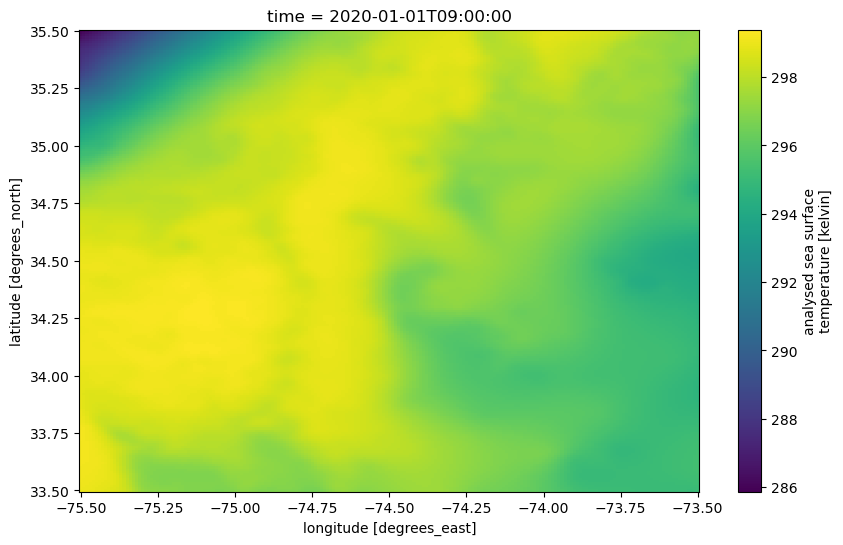

In [8]:
ds_subset['analysed_sst'].plot(figsize=(10,6), x='lon', y='lat');

## Create a data cube by combining multiple netCDF files

When we open multiple files, we use `open_mfdataset()`. Once again, we are doing lazy loading. Note this method works best if you are in the same Amazon Web Services (AWS) region as the data (us-west-2) and can use S3 connection. For the EDM workshop, we are on an Azure JupyterHub and are using https connection so this is much much slower. If we had spun up this JupyterHub on AWS us-west-2 where the NASA data are hosted, we could load a whole year of data instantly. We will load just a few days so it doesn't take so long.

In [9]:
fileset = earthaccess.open(results[0:6])
ds = xr.open_mfdataset(fileset[0:5])

QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
ds

<xarray.Dataset> Size: 143GB
Dimensions:           (time: 5, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 40B 2020-01-01T09:00:00 ... 2020-...
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 26GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 26GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 13GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 26GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] 26GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 26GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

We can subset a spatial box as we did with a single file.

In [11]:
ds_subset = ds.sel(lat=slice(33.5, 35.5), lon=slice(-75.5, -73.5)) 
ds_subset

<xarray.Dataset> Size: 9MB
Dimensions:           (time: 5, lat: 201, lon: 201)
Coordinates:
  * time              (time) datetime64[ns] 40B 2020-01-01T09:00:00 ... 2020-...
  * lat               (lat) float32 804B 33.5 33.51 33.52 ... 35.48 35.49 35.5
  * lon               (lon) float32 804B -75.5 -75.49 -75.48 ... -73.51 -73.5
Data variables:
    analysed_sst      (time, lat, lon) float64 2MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 2MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    mask              (time, lat, lon) float32 808kB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 2MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] 2MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 2MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

We can subset a slice of days also.

In [12]:
ds_subset_time = ds_subset.sel(time=slice("2020-01-01", "2020-01-04"))
ds_subset_time

<xarray.Dataset> Size: 7MB
Dimensions:           (time: 4, lat: 201, lon: 201)
Coordinates:
  * time              (time) datetime64[ns] 32B 2020-01-01T09:00:00 ... 2020-...
  * lat               (lat) float32 804B 33.5 33.51 33.52 ... 35.48 35.49 35.5
  * lon               (lon) float32 804B -75.5 -75.49 -75.48 ... -73.51 -73.5
Data variables:
    analysed_sst      (time, lat, lon) float64 1MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 1MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    mask              (time, lat, lon) float32 646kB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 1MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] 1MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 1MB dask.array<chunksize=(1, 201, 201), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

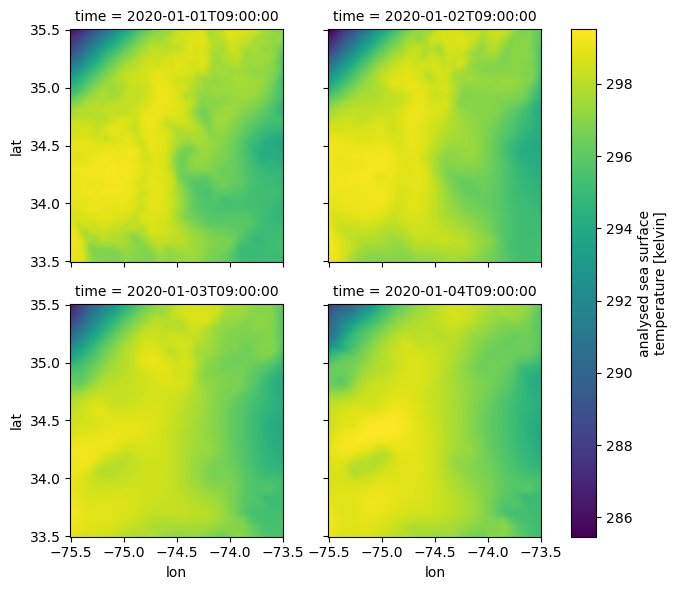

In [13]:
ds_subset_time['analysed_sst'].plot(x='lon', y='lat', col="time", col_wrap=2);

## Summary

We learned how to subset `xarray` data cubes by time and space using `sel()` and `slice()`. Next we will show how to select via a shapefile. If you want to jump instead to creating monthly and seasonal means from a data cube, you can look at the `4-data-cube.ipynb` tutorial or explore the [gallery](https://docs.xarray.dev/en/latest/gallery.html) of `xarray` examples.